# Assignment 1 Matteo Breganni 869549

In [ ]:
# Basic imports
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractors=[identity], normalize=False):  # Edited to take an array of features extractors

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = concatenateFeatures(signal, feature_extractors)  # Edited to directly call the concatenate function
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [ ]:
# Energy feature extractor
def energy(signal):
  return np.sum((signal*1.0) ** 2, keepdims=True)

In [ ]:
# Duration feature extractor
def duration(signal):
  return np.array(signal.shape)

In [ ]:
# Zero Crossing Rate feature extractor
def zcr(signal):
    # Finds sign changes, treating 0s as if they were positive numbers
    signalWithoutZeros = np.where(signal == 0, 1, signal)
    signChanges = np.diff(np.sign(signalWithoutZeros))

    # Count the number of zero crossings
    zcr = np.sum(signChanges != 0) / len(signal)

    return np.array(zcr)

In [ ]:
# Explanation of how the zcr function works
print("First Example")
exampleSignal = np.array([1, 1, -2, -3, 1, 1, 0, 0, -1, 0, -1])
print(exampleSignal, "Example signal")

# The sign function returns 1 for potitive values, -1 for negative values or 0.
print(np.sign(exampleSignal), "Sign function result (the sign function returns 1 for potitive values, -1 for negative values or 0)")

# The diff function subtracts the current element of the array from the next element
# This means it will return 0 if the sign didn't change, and any other positive or negative number if the sign changed
exampleSignChanges = np.diff(np.sign(exampleSignal))
print(exampleSignChanges, "Diff function result (the diff function subtracts the current element of the array from the next element)")
print(np.sum(exampleSignChanges != 0), "crossings")
print(np.sum(exampleSignChanges != 0) / len(exampleSignal), "zcr result")

# However, this also counts the value 0 as being a sign change, meaning if the function goes from -1, to 0, to 1, the function will calculate 2 sign changes, which is wrong.
# Also, I have decided to consider 0 a positive number, which I think is better than trating it as neutral and ignoring its existence (also the results I got from removing all zeros were a little worse).
# To do this, I simply transformed all 0s to 1s in the signal, since they will still be converted to 1 by the sign function and be treated like a normal positive number

print("\nSecond Example")
print(exampleSignal, "Example signal")
exampleSignalWithoutZeros = np.where(exampleSignal == 0, 1, exampleSignal)
print(exampleSignalWithoutZeros, "Example signal without zeros")
print(np.sign(exampleSignalWithoutZeros), "Sign function result")
exampleSignChanges = np.diff(np.sign(exampleSignalWithoutZeros))
print(exampleSignChanges, "Diff function result")
print(np.sum(exampleSignChanges != 0), "crossings")

print(np.sum(exampleSignChanges != 0) / len(exampleSignal), "zcr result")

First Example
[ 1  1 -2 -3  1  1  0  0 -1  0 -1] Example signal
[ 1  1 -1 -1  1  1  0  0 -1  0 -1] Sign function result (the sign function returns 1 for potitive values, -1 for negative values or 0)
[ 0 -2  0  2  0 -1  0 -1  1 -1] Diff function result (the diff function subtracts the current element of the array from the next element)
6 crossings
0.5454545454545454 zcr result

Second Example
[ 1  1 -2 -3  1  1  0  0 -1  0 -1] Example signal
[ 1  1 -2 -3  1  1  1  1 -1  1 -1] Example signal without zeros
[ 1  1 -1 -1  1  1  1  1 -1  1 -1] Sign function result
[ 0 -2  0  2  0  0  0 -2  2 -2] Diff function result
5 crossings
0.45454545454545453 zcr result


In [ ]:
# Concatenates different features extractor's outputs
def concatenateFeatures(signal, feature_extractors):
  features = []

  for extractor_function in feature_extractors:
    if callable(extractor_function):
      # Applies the feature extractor to the input signal
      feature = extractor_function(signal)

      # Makes sure that the extracted feature is at least 1-dimensional and appends it
      feature = np.atleast_1d(feature)
      features.append(feature)
    else:
      print(f"{extractor_function} isn't a valid function.")

  # Returns the features concatenated
  return np.concatenate(features, axis=-1)

In [ ]:
# Parameters to be tested in cross-validation
paramGrid = {'C': [100, 500, 1000],
             'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Optimizes hyperparameters and trains the model
def crossValidationAndTraining(X_training, y_training, param_grid=paramGrid, cv=2):

  # Support Vector Machine initialization
  classifier = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=cv)

  classifier = training(classifier, X_training, y_training)

  # Result of the cross validation for parameters selection
  print('Best parameters combination:')
  print(' C: '+str(classifier.best_estimator_.C))
  print(' gamma: '+str(classifier.best_estimator_.gamma))

  return classifier

def training(classifier, X_training, y_training):
  # Training
  t0 = time()
  classifier = classifier.fit(X_training, y_training)
  print('Training completed in %0.3fs' % (time() - t0))

  return classifier

def predict(classifier, X_testing, y_testing):
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))

  # Confusion matrix
  print('Confusion matrix:')
  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, cmap=plt.cm.Blues);
  plt.xlabel('Prediction');
  plt.ylabel('Ground truth');

**Models from the class & more**

Training completed in 0.115s
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           3       0.17      0.58      0.26        19
           4       0.12      0.27      0.17        11
           5       0.10      0.14      0.12        14
           6       0.40      0.29      0.33        14
           7       0.14      0.16      0.15        19
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        14

    accuracy                           0.16       150
   macro avg       0.14      0.15      0.11       150
weighted avg       0.15      0.16      0.12       150

Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


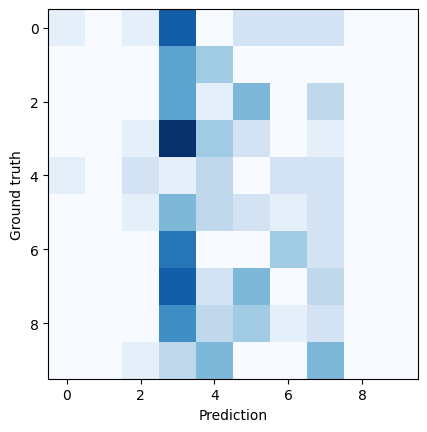

In [ ]:
# Model with energy, no normalization and not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[energy])

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)

Training completed in 0.114s
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        17
           1       0.22      0.40      0.29        10
           2       0.00      0.00      0.00        15
           3       0.38      0.26      0.31        19
           4       0.38      0.27      0.32        11
           5       0.00      0.00      0.00        14
           6       0.67      0.14      0.24        14
           7       0.33      0.05      0.09        19
           8       0.26      0.71      0.38        17
           9       0.06      0.14      0.08        14

    accuracy                           0.24       150
   macro avg       0.26      0.24      0.21       150
weighted avg       0.27      0.24      0.21       150

Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


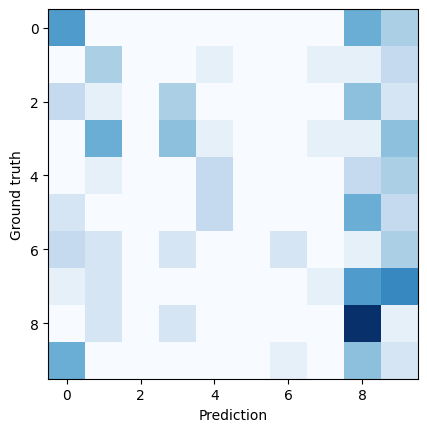

In [ ]:
# Model with duration, no normalization and not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[duration])

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)

Training completed in 0.093s
              precision    recall  f1-score   support

           0       0.67      0.24      0.35        17
           1       0.11      0.10      0.11        10
           2       0.00      0.00      0.00        15
           3       0.39      0.63      0.48        19
           4       0.46      0.55      0.50        11
           5       0.17      0.14      0.15        14
           6       0.50      0.14      0.22        14
           7       0.38      0.16      0.22        19
           8       0.09      0.12      0.10        17
           9       0.26      0.71      0.38        14

    accuracy                           0.28       150
   macro avg       0.30      0.28      0.25       150
weighted avg       0.31      0.28      0.25       150

Confusion matrix:


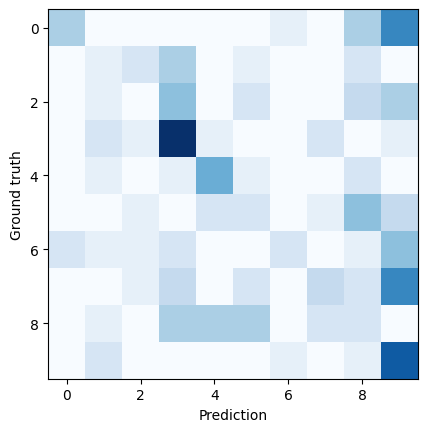

In [ ]:
# Model with energy and duration, normalized not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[energy, duration], normalize=True)

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)

Training completed in 3.877s
Best parameters combination:
 C: 1000
 gamma: 0.1
              precision    recall  f1-score   support

           0       0.50      0.47      0.48        17
           1       0.15      0.20      0.17        10
           2       0.00      0.00      0.00        15
           3       0.38      0.53      0.44        19
           4       0.45      0.45      0.45        11
           5       0.19      0.21      0.20        14
           6       0.47      0.50      0.48        14
           7       0.36      0.21      0.27        19
           8       0.14      0.12      0.13        17
           9       0.36      0.57      0.44        14

    accuracy                           0.33       150
   macro avg       0.30      0.33      0.31       150
weighted avg       0.31      0.33      0.31       150

Confusion matrix:


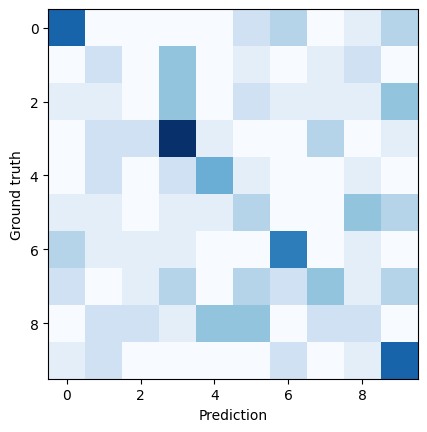

In [ ]:
# Model with energy and duration, normalized and cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[energy, duration], normalize=True)

clf = crossValidationAndTraining(X_train, y_train)

predict(clf, X_test, y_test)

**Assignment models with zero crossing rate**

Training completed in 0.083s
              precision    recall  f1-score   support

           0       0.29      0.76      0.42        17
           1       0.50      0.10      0.17        10
           2       0.33      0.20      0.25        15
           3       0.00      0.00      0.00        19
           4       0.20      0.64      0.30        11
           5       0.19      0.43      0.27        14
           6       0.86      0.86      0.86        14
           7       0.22      0.11      0.14        19
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        14

    accuracy                           0.29       150
   macro avg       0.26      0.31      0.24       150
weighted avg       0.24      0.29      0.23       150

Confusion matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


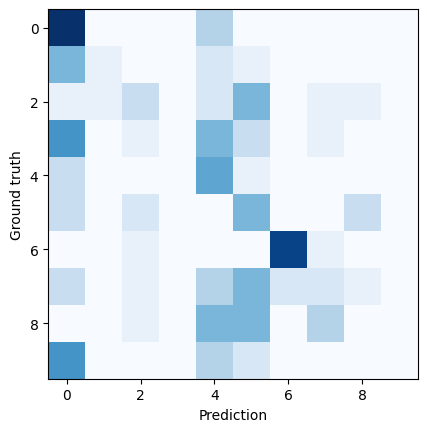

In [ ]:
# Model with zero crossing rate, no normalization and not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr])

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)
# From these results we can see how zero crossing rate already seems to be a better feature than energy and duration, even by itself. However, a 29% accuracy and a 24% macro avg isn't acceptable

Training completed in 0.081s
              precision    recall  f1-score   support

           0       0.42      0.59      0.49        17
           1       0.24      0.60      0.34        10
           2       0.25      0.13      0.17        15
           3       0.20      0.05      0.08        19
           4       0.12      0.18      0.15        11
           5       0.18      0.50      0.27        14
           6       0.83      0.71      0.77        14
           7       0.20      0.05      0.08        19
           8       0.36      0.24      0.29        17
           9       0.00      0.00      0.00        14

    accuracy                           0.29       150
   macro avg       0.28      0.31      0.26       150
weighted avg       0.28      0.29      0.26       150

Confusion matrix:


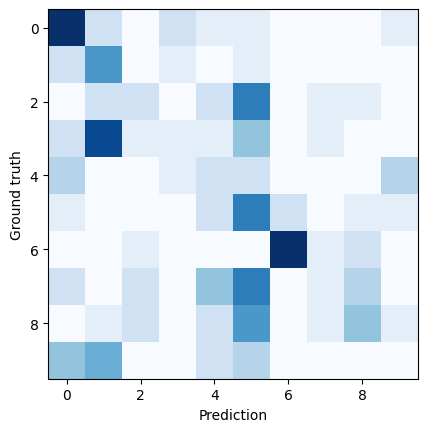

In [ ]:
# Model with zero crossing rate and energy, normalized not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, energy], normalize=True)

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)
# zrc together with energy seems to work a little bit better, raising the macro avg by a couple of points

Training completed in 4.344s
Best parameters combination:
 C: 100
 gamma: 1.0
              precision    recall  f1-score   support

           0       0.44      0.47      0.46        17
           1       0.24      0.60      0.34        10
           2       0.30      0.20      0.24        15
           3       0.44      0.21      0.29        19
           4       0.44      0.36      0.40        11
           5       0.23      0.50      0.31        14
           6       0.80      0.86      0.83        14
           7       0.25      0.16      0.19        19
           8       0.42      0.29      0.34        17
           9       0.11      0.07      0.09        14

    accuracy                           0.35       150
   macro avg       0.37      0.37      0.35       150
weighted avg       0.37      0.35      0.34       150

Confusion matrix:


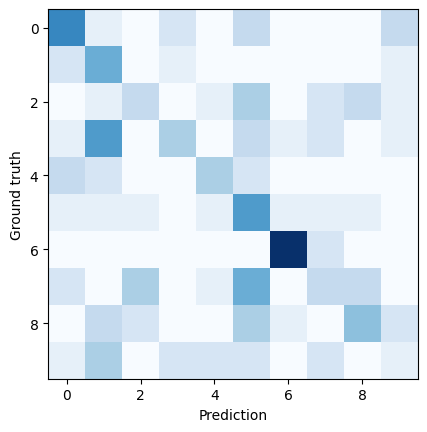

In [ ]:
# Model with zero crossing rate and energy, normalized and cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, energy], normalize=True)

clf = crossValidationAndTraining(X_train, y_train)

predict(clf, X_test, y_test)
# Adding the cross validation makes the results even better, but they're still low levels of accuracy

Training completed in 0.123s
              precision    recall  f1-score   support

           0       0.32      0.71      0.44        17
           1       0.38      0.60      0.46        10
           2       0.50      0.47      0.48        15
           3       0.50      0.16      0.24        19
           4       0.28      0.45      0.34        11
           5       0.20      0.43      0.27        14
           6       0.92      0.86      0.89        14
           7       0.33      0.11      0.16        19
           8       0.50      0.12      0.19        17
           9       0.50      0.21      0.30        14

    accuracy                           0.39       150
   macro avg       0.44      0.41      0.38       150
weighted avg       0.45      0.39      0.36       150

Confusion matrix:


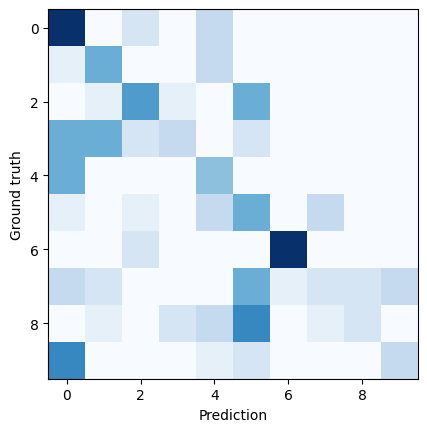

In [ ]:
# Model with zero crossing rate and duration, normalized not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, duration], normalize=True)

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)
# As predictable (since duration was already better on it's own compared to energy), putting zcr together with duration gives us better results

Training completed in 3.143s
Best parameters combination:
 C: 500
 gamma: 0.5
              precision    recall  f1-score   support

           0       0.38      0.65      0.48        17
           1       0.40      0.60      0.48        10
           2       0.42      0.53      0.47        15
           3       0.38      0.26      0.31        19
           4       0.28      0.45      0.34        11
           5       0.19      0.29      0.23        14
           6       1.00      0.71      0.83        14
           7       0.22      0.11      0.14        19
           8       0.36      0.29      0.32        17
           9       1.00      0.14      0.25        14

    accuracy                           0.39       150
   macro avg       0.46      0.40      0.39       150
weighted avg       0.45      0.39      0.38       150

Confusion matrix:


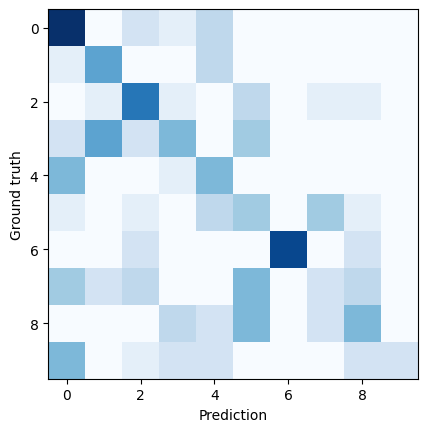

In [ ]:
# Model with zero crossing rate and duration, normalized and cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, duration], normalize=True)

clf = crossValidationAndTraining(X_train, y_train)

predict(clf, X_test, y_test)
# Including cross validation makes the model slightly better

Training completed in 0.069s
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.35      0.70      0.47        10
           2       0.57      0.53      0.55        15
           3       0.50      0.37      0.42        19
           4       0.42      0.73      0.53        11
           5       0.21      0.43      0.29        14
           6       1.00      0.93      0.96        14
           7       0.67      0.32      0.43        19
           8       0.71      0.29      0.42        17
           9       0.89      0.57      0.70        14

    accuracy                           0.55       150
   macro avg       0.62      0.57      0.56       150
weighted avg       0.63      0.55      0.56       150

Confusion matrix:


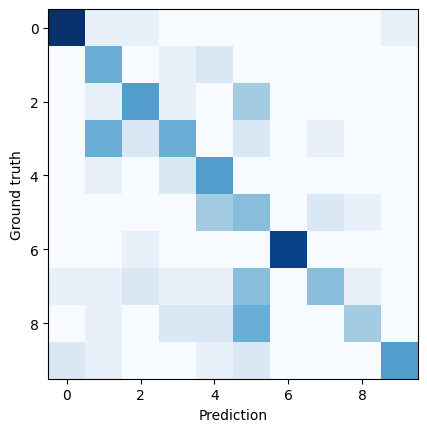

In [ ]:
# Model with zero crossing rate, energy and duration, normalized and not cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, energy, duration], normalize=True)

clf = training(SVC(kernel='rbf', class_weight='balanced'), X_train, y_train)

predict(clf, X_test, y_test)
# All three features put together and normalized reach better results, surpassing the 50% mark

Training completed in 11.817s
Best parameters combination:
 C: 10
 gamma: 1
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.44      0.70      0.54        10
           2       0.69      0.60      0.64        15
           3       0.62      0.42      0.50        19
           4       0.50      0.64      0.56        11
           5       0.36      0.64      0.46        14
           6       0.93      0.93      0.93        14
           7       0.50      0.26      0.34        19
           8       0.58      0.41      0.48        17
           9       0.56      0.71      0.62        14

    accuracy                           0.58       150
   macro avg       0.60      0.60      0.58       150
weighted avg       0.61      0.58      0.58       150

Confusion matrix:


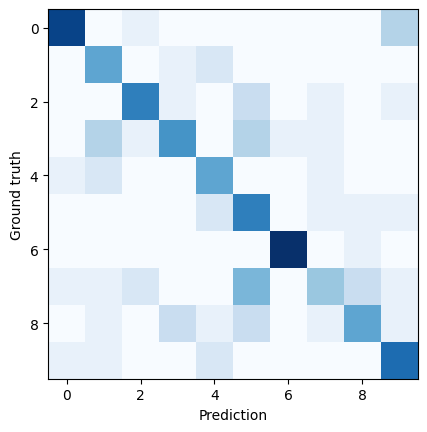

In [ ]:
# Model with zero crossing rate, energy and duration, normalized and cross validated
# Trial and error to try to get the best result possible, reacing a 58% accuracy and macro avg

paramGrid2 = {'C': [0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100], }

# Model with zero crossing rate, energy and duration, normalized and cross validated
X_train, X_test, y_train, y_test = load_data(feature_extractors=[zcr, energy, duration], normalize=True)

clf = crossValidationAndTraining(X_train, y_train, paramGrid2, cv=3)

predict(clf, X_test, y_test)
# Adding the cross validation with custom parameters for the grid search and a 3 k-folds helps us reach the best result, close to the 60% mark
# Although we can say that the model has defenitely learned something and can do a decent job at recognising numbers in audio files, in my opinion this result isn't good enough to consider the model a good predictor.
# In my opinion, possibly better features (like pitch) and some kind of fliters could help reach much better results. A bigger dataset and different models could also help.
# Something we can see for sure is that using multiple features (normalized) at the same time, with an optimized svm model helps us reach the best results.